In [17]:
#Problem Setup/Definition:
import numpy as np
np.random.seed(42)
import random
random.seed(42)
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfTransformer
from string import punctuation
from string import digits
from nltk.corpus import wordnet
from sklearn.feature_extraction import text, stop_words
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.svm import LinearSVC
import math 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory

cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)
%matplotlib inline

/usr/lib/python3/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/tmp/tmpzdpj2waq'", use "location='/tmp/tmpzdpj2waq'" instead.


In [2]:
def my_custom_preprocessor(doc_string):
    # do all data preprocessing here
    
    # Lower case
    doc_string=doc_string.lower()
    
    # Remove Numbers
    remove_digits = str.maketrans('', '', digits)
    doc_string.translate(remove_digits)
    
    # Convert to tokenized form....
    tokens = nltk.tokenize.word_tokenize(doc_string)
    # Iterate through list of tokens (words) and remove all numbers
    tokens = [word for word in tokens if word.isalpha()]
    # Iterate through list of tokens (words) and stem (shorten) each word
    port_stemmer = PorterStemmer()
    tokens = [port_stemmer.stem(words) for words in tokens ]
    
    ###############################
    #### Lemmatize with pos_tag ###
    ###############################
    
    lemmatizer = WordNetLemmatizer()
    
    # Convert between two different tagging schemes
    def change_tags(penntag):
        morphy_tag = {'NN':'n', 'JJ':'a',
                      'VB':'v', 'RB':'r'}
        try:
            return morphy_tag[penntag[:2]]
        except:
            return 'n'
        
    tokens = [lemmatizer.lemmatize(word.lower(), pos=change_tags(tag)) for word, tag in pos_tag(tokens)]
    
    # Rejoin List of tokens and return that single document-string
    return ' '.join(tokens)

###########################
#### RoC Curve Function ###
###########################

def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

def fit_predict_and_plot_roc(pipe, train_data, train_label, test_data, test_label):
    pipe.fit(train_data, train_label)

    if hasattr(pipe, 'decision_function'):
        prob_score = pipe.decision_function(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score)
    else:
        prob_score = pipe.predict_proba(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score[:,1])

    plot_roc(fpr, tpr)
    
#####################################################
#### Define Custom stop words for CountVectorizer ###
#####################################################

stop_words_skt = text.ENGLISH_STOP_WORDS
stop_words_en = stopwords.words('english')
combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))

# Run stop_words through the same pre-processor as the document-matrix
# This will apply stemmed/lemmatized stop_woirds to stemmed/lemmatized tokenized document lists
def process_stop_words(stop_word_set):
    doc_string = ' '.join(stop_word_set)
    return my_custom_preprocessor(doc_string).split()

##################################
#### Import Dataset Train/Test ###
##################################

# Only take a specific selection (8) of the 20 available categories
categories = ['comp.graphics', 'comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles',
'rec.sport.baseball', 'rec.sport.hockey']

# Load a training & test data sets consisting of those 8 categories
train_dataset = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = None)
test_dataset = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = None)
print("\n\n" + '-'*40 + "\n\n")

#############################################
#### Define Class data set arrys (0 or 1) ###
#############################################
# Categorize the 8 news categories into two (binary) Classes 
# 0 = computer technology
# 1 = recreational activity
training_data_class = [] 
test_data_class = []

# Categories are mapped 0-7, (0-3) = Comp, (4-7) = Recreation
print(train_dataset.target_names)
print(train_dataset.target)

for category in train_dataset.target:
    if category < 4:
        training_data_class.append(0)
    else:
        training_data_class.append(1)
        
# Reshape test dataset
for category in test_dataset.target:
    if category < 4:
        test_data_class.append(0)
    else:
        test_data_class.append(1)
        
# Sanity Checks, values should all be either 1 or 0
print("First 10 articles Classification (Train): \n" + str(training_data_class[0:10]))
print("First 10 articles Classification (Train): \n" + str(test_data_class[0:10]))
# This will be used for the classification categories only!!!!
# Each data point refers to the classification of a single article in dataset



----------------------------------------


['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
[6 7 4 ... 6 6 2]
First 10 articles Classification (Train): 
[1, 1, 1, 0, 0, 0, 0, 1, 1, 0]
First 10 articles Classification (Train): 
[1, 0, 0, 1, 1, 1, 1, 1, 1, 1]


In [3]:
# Define the CountVectorizer = document-term matrix
train_count_vectorizer = CountVectorizer(min_df=3, preprocessor=my_custom_preprocessor, stop_words=process_stop_words(combined_stopwords))
test_count_vectorizer = CountVectorizer(min_df=3, preprocessor=my_custom_preprocessor, stop_words=process_stop_words(combined_stopwords))

# Fit + count the train_doc_term_matrix: setting the vocabulary (word-features) based on words found in the train_dataset
train_doc_term_matrix = train_count_vectorizer.fit_transform(train_dataset.data)

# Fit the test_count_doc_term_matric to train_dataset words; then count the occurence of those words in the test_dataset
test_count_vectorizer.fit(train_dataset.data)
test_count_doc_term_matrix = test_count_vectorizer.transform(test_dataset.data)

# Start TD-DIF Transform process; created TDIF matrix with train_doc_term_matrix vocabulary; apply test_dataset transform
tfidf_transformer = TfidfTransformer()
train_tfidf = tfidf_transformer.fit_transform(train_doc_term_matrix)
test_tfidf = tfidf_transformer.fit_transform(test_count_doc_term_matrix)

print("Number of articles within the TRAIN Dataset: " + str(len(train_dataset.filenames)))
print("Number of Features (unique words) in TRAINING dataset (After Processing): "+ str(len(train_count_vectorizer.get_feature_names())))
print("Shape of TRAINING document-count-matrix: " + str(train_doc_term_matrix.shape))
print("Shape of TRAINING TF-IDF Matrix: " + str(train_tfidf.shape))
print("\n\n" + '-'*40 + "\n\n")

print("Number of articles within the TEST Dataset: " + str(len(test_dataset.filenames)))
print("Number of Features (unique words) in TEST dataset (After Processing): "+ str(len(test_count_vectorizer.get_feature_names())))
print("Shape of TEST document-count-matrix: " + str(test_count_doc_term_matrix.shape))
print("Shape of TEST TF-IDF Matrix: " + str(test_tfidf.shape))
print("\n\n" + '-'*40 + "\n\n")


##############################
## Dimensionality Reduction ##
##############################
# Only need on SVD Model, Choosing NMF
from sklearn.decomposition import NMF

nmf_settings = NMF(n_components=50, init='random', random_state=0)
reduced_NMF_train_matrix = nmf_settings.fit_transform(train_tfidf)
reduced_NMF_test_matrix = nmf_settings.transform(test_tfidf)

nmf_settings_components = nmf_settings.components_
print("Shape of reduced TRAIN tf-idf matrix after NMF Dimensionality Reduction (top 50 words): " + str(reduced_NMF_train_matrix.shape))
print("Shape of reduced TEST tf-idf matrix after NMF Dimensionality Reduction (top 50 words): " + str(reduced_NMF_train_matrix.shape))


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['anywh', 'becau', 'el', 'elsewh', 'everywh', 'far', 'ind', 'otherwi', 'plea', 'somewh'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Number of articles within the TRAIN Dataset: 4732
Number of Features (unique words) in TRAINING dataset (After Processing): 10847
Shape of TRAINING document-count-matrix: (4732, 10847)
Shape of TRAINING TF-IDF Matrix: (4732, 10847)


----------------------------------------


Number of articles within the TEST Dataset: 3150
Number of Features (unique words) in TEST dataset (After Processing): 10847
Shape of TEST document-count-matrix: (3150, 10847)
Shape of TEST TF-IDF Matrix: (3150, 10847)


----------------------------------------


Shape of reduced TRAIN tf-idf matrix after NMF Dimensionality Reduction (top 50 words): (4732, 50)
Shape of reduced TEST tf-idf matrix after NMF Dimensionality Reduction (top 50 words): (4732, 50)


In [8]:
######################################################
#### Perform Predictions using Logistic Regression ###
######################################################
# 'lbfgs' solver supports no regularization 
log_reg_trained = LogisticRegression(penalty='none',random_state=0, solver='lbfgs', max_iter=5000).fit(reduced_NMF_train_matrix, training_data_class)
log_reg_predicted = log_reg_trained.predict(reduced_NMF_test_matrix)

############## Log Regression (NO REGULARIZATION!): ############### 

Accuracy: 0.9707936507936508
Precision: 0.968125
Recall: 0.9742138364779874
Confusion Matrix: 
[[1509   51]
 [  41 1549]]
F1-score: 0.9711598746081505


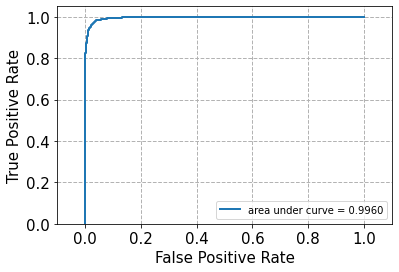

In [16]:
#############################################
#### Logistic Regrssion NO REGULARIZATION ###
#############################################
log_accuracy = metrics.accuracy_score(test_data_class, log_reg_predicted)
log_precision = metrics.precision_score(test_data_class, log_reg_predicted)
log_recall = metrics.recall_score(test_data_class, log_reg_predicted)
log_f1 = 2 * (log_precision * log_recall) / (log_precision + log_recall)
print("############## Log Regression (NO REGULARIZATION!): ############### \n")
print("Accuracy: " + str(log_accuracy))
print("Precision: " + str(log_precision))
print("Recall: " + str(log_recall))
print("Confusion Matrix: \n" + str(metrics.confusion_matrix(test_data_class, log_reg_predicted)))
print("F1-score: "+ str(log_f1))

# ROC Curve
dec_function_score = log_reg_trained.predict_proba(reduced_NMF_test_matrix)
fpr, tpr, thresholds = metrics.roc_curve(test_data_class, dec_function_score[:,1])
plot_roc(fpr,tpr)

In [25]:
#############################################
#### Logistic Regrssion CROSS VALIDATION  ###
#############################################
# Define & train Logistic Regression models with L1 (Lasso) & L2 (Ridge) Regularization
log_reg_l1_trained = LogisticRegression(penalty='l1',random_state=0, solver='liblinear', max_iter=5000).fit(reduced_NMF_train_matrix, training_data_class)
log_reg_l2_trained = LogisticRegression(penalty='l2',random_state=0, solver='liblinear', max_iter=5000).fit(reduced_NMF_train_matrix, training_data_class)

# Defining how to split the data set; k-fold, k=5
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

# Create a Dictionary with key 'C' and value [10^-3  < k < 3]
hyper_param_range = {'C': [math.pow(10, k) for k in range(-3,4)]}
print("Hyper parameter values that will be tested: \n" + str(hyper_param_range))
print("\n\n" + '-'*40 + "\n\n")  

# Perform grid_search to find the best value of 'C'
l1_grid_search = GridSearchCV(log_reg_l1_trained, hyper_param_range, cv=5, scoring='accuracy')
l2_grid_search = GridSearchCV(log_reg_l2_trained, hyper_param_range, cv=5, scoring='accuracy')

l1_grid_search.fit(reduced_NMF_train_matrix, training_data_class)
l2_grid_search.fit(reduced_NMF_train_matrix, training_data_class)

##############################################
#### Print Findings L1-Logistic Regression ###
##############################################
# Print out tested parameter values (C=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]) vs. mean vs. std
l1_grid_mean = l1_grid_search.cv_results_['mean_test_score']
l1_grid_std =  l1_grid_search.cv_results_['std_test_score']
l1_grid_params =  l1_grid_search.cv_results_['params']

print("L1 Logistic Regression")
print("Average Accuracy vs. C-value: \n")
for mean, standard_dev, hyper_param_values in zip(l1_grid_mean, l1_grid_std, l1_grid_params):
    print("Mean: " + str(mean) + "    std: " + str(standard_dev) + "   C: " + str(hyper_param_values))
print("\n\n" + '-'*40 + "\n\n") 

##############################################
#### Print Findings L2-Logistic Regression ###
##############################################
# Print out tested parameter values (C=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]) vs. mean vs. std
l2_grid_mean = l2_grid_search.cv_results_['mean_test_score']
l2_grid_std =  l2_grid_search.cv_results_['std_test_score']
l2_grid_params =  l2_grid_search.cv_results_['params']

print("L2 Logistic Regression")
print("Average Accuracy vs. C-value: \n")
for mean, standard_dev, hyper_param_values in zip(l2_grid_mean, l2_grid_std, l2_grid_params):
    print("Mean: " + str(mean) + "    std: " + str(standard_dev) + "   C: " + str(hyper_param_values))
print("\n\n" + '-'*40 + "\n\n") 

Hyper parameter values that will be tested: 
{'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}


----------------------------------------


L1 Logistic Regression
Average Accuracy vs. C-value: 

Mean: 0.495139429956846    std: 0.0003960683087326988   C: {'C': 0.001}
Mean: 0.495139429956846    std: 0.0003960683087326988   C: {'C': 0.01}
Mean: 0.6876543485492185    std: 0.011446503171945148   C: {'C': 0.1}
Mean: 0.9628052088379683    std: 0.0032465533301380797   C: {'C': 1.0}
Mean: 0.9731612681417449    std: 0.00461350441262535   C: {'C': 10.0}
Mean: 0.9735834313767076    std: 0.003958005671371865   C: {'C': 100.0}
Mean: 0.9737944013698538    std: 0.004749436857118839   C: {'C': 1000.0}


----------------------------------------


L2 Logistic Regression
Average Accuracy vs. C-value: 

Mean: 0.5054948195146127    std: 0.0011878269781774255   C: {'C': 0.001}
Mean: 0.6020697384195334    std: 0.005817352551430027   C: {'C': 0.01}
Mean: 0.8970821398831517    std: 0.004923241192342682   C: {

############## Log Regression (NO REGULARIZATION!): ############### 

Accuracy: 0.9707936507936508
Precision: 0.968125
Recall: 0.9742138364779874
Confusion Matrix: 
[[1509   51]
 [  41 1549]]
F1-score: 0.9711598746081505
############## Log Regression (OPTIMAL L1!): ############### 

Accuracy: 0.9711111111111111
Precision: 0.9669781931464174
Recall: 0.9761006289308176
Confusion Matrix: 
[[1507   53]
 [  38 1552]]
F1-score: 0.9715179968701095
############## Log Regression (OPTIMAL L2!): ############### 

Accuracy: 0.9692063492063492
Precision: 0.9616573902288188
Recall: 0.9779874213836478
Confusion Matrix: 
[[1498   62]
 [  35 1555]]
F1-score: 0.9697536638603057


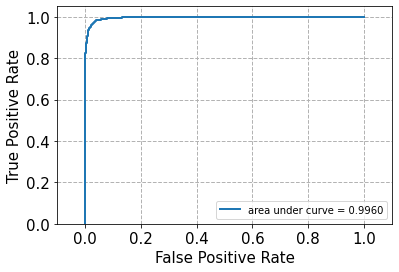

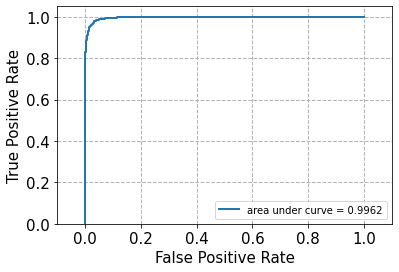

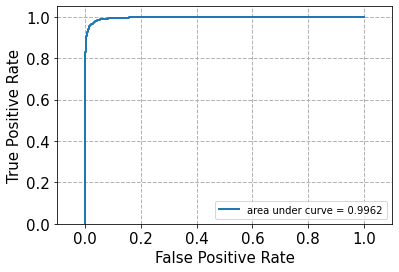

In [34]:
################################################
#### Logistic Regrssion - Optimal 'C' values  ##
################################################
optimal_log_l1_trained = LogisticRegression(penalty='l1', C=100, random_state=0, solver='liblinear', max_iter=5000).fit(reduced_NMF_train_matrix, training_data_class)
optimal_log_l2_trained = LogisticRegression(penalty='l2', C=100, random_state=0, solver='liblinear', max_iter=5000).fit(reduced_NMF_train_matrix, training_data_class)

# Make Predictions using both l1 & l2 optimal 'C' values
optimal_log_l1_predicted = optimal_log_l1_trained.predict(reduced_NMF_test_matrix)
optimal_log_l2_predicted = optimal_log_l2_trained.predict(reduced_NMF_test_matrix)

################################
#### Print & Compare Results ###
################################
log_accuracy = metrics.accuracy_score(test_data_class, log_reg_predicted)
log_precision = metrics.precision_score(test_data_class, log_reg_predicted)
log_recall = metrics.recall_score(test_data_class, log_reg_predicted)
log_f1 = 2 * (log_precision * log_recall) / (log_precision + log_recall)
print("############## Log Regression (NO REGULARIZATION!): ############### \n")
print("Accuracy: " + str(log_accuracy))
print("Precision: " + str(log_precision))
print("Recall: " + str(log_recall))
print("Confusion Matrix: \n" + str(metrics.confusion_matrix(test_data_class, log_reg_predicted)))
print("F1-score: "+ str(log_f1))

# ROC Curve
dec_function_score = log_reg_trained.predict_proba(reduced_NMF_test_matrix)
fpr, tpr, thresholds = metrics.roc_curve(test_data_class, dec_function_score[:,1])
plot_roc(fpr,tpr)

#########################
optimal_l1_log_accuracy = metrics.accuracy_score(test_data_class, optimal_log_l1_predicted)
optimal_l1_log_precision = metrics.precision_score(test_data_class, optimal_log_l1_predicted)
optimal_l1_log_recall = metrics.recall_score(test_data_class, optimal_log_l1_predicted)
optimal_l1_log_f1 = 2 * (optimal_l1_log_precision * optimal_l1_log_recall) / (optimal_l1_log_precision + optimal_l1_log_recall)
print("############## Log Regression (OPTIMAL L1!): ############### \n")
print("Accuracy: " + str(optimal_l1_log_accuracy))
print("Precision: " + str(optimal_l1_log_precision))
print("Recall: " + str(optimal_l1_log_recall))
print("Confusion Matrix: \n" + str(metrics.confusion_matrix(test_data_class, optimal_log_l1_predicted)))
print("F1-score: "+ str(optimal_l1_log_f1))

# ROC Curve
dec_function_score = optimal_log_l1_trained.predict_proba(reduced_NMF_test_matrix)
fpr, tpr, thresholds = metrics.roc_curve(test_data_class, dec_function_score[:,1])
plot_roc(fpr,tpr)

##########################

optimal_l2_log_accuracy = metrics.accuracy_score(test_data_class, optimal_log_l2_predicted)
optimal_l2_log_precision = metrics.precision_score(test_data_class, optimal_log_l2_predicted)
optimal_l2_log_recall = metrics.recall_score(test_data_class, optimal_log_l2_predicted)
optimal_l2_log_f1 = 2 * (optimal_l2_log_precision * optimal_l2_log_recall) / (optimal_l2_log_precision + optimal_l2_log_recall)
print("############## Log Regression (OPTIMAL L2!): ############### \n")
print("Accuracy: " + str(optimal_l2_log_accuracy))
print("Precision: " + str(optimal_l2_log_precision))
print("Recall: " + str(optimal_l2_log_recall))
print("Confusion Matrix: \n" + str(metrics.confusion_matrix(test_data_class, optimal_log_l2_predicted)))
print("F1-score: "+ str(optimal_l2_log_f1))

# ROC Curve
dec_function_score = optimal_log_l2_trained.predict_proba(reduced_NMF_test_matrix)
fpr, tpr, thresholds = metrics.roc_curve(test_data_class, dec_function_score[:,1])
plot_roc(fpr,tpr)

